In [26]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
import math
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

from IPython.display import display

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn import neighbors

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from timeit import default_timer as timer

import pydotplus
from sklearn import tree
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

In [286]:
# Upload dataset
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()


# Make new features
df['tv_neg'] = 7 - df['tvtot']
df['trust_neg'] = 10 - df['ppltrst']
df['fairness_neg'] = 10 - df['pplfair']
df['helpful_neg'] = 10 - df['pplhlp']
df['sclmeet_neg'] = (7 - df['sclmeet'])
df['sclact_neg'] = 5 - df['sclact']

df['young'] = ((df['agea']>=20)*1)*((df['agea']<40)*1)*1
df['middle_age'] = ((df['agea']>=40)*1)*((df['agea']<60)*1)*1
df['elderly'] = (df['agea']>=60)*1

df['age_log'] = np.log(df['agea'])
df['age_plus_happy'] = df['age_log'] + df['happy']

df['happy_squared'] = df['happy']**2

df.drop(columns=['agea','sclmeet','happy'], inplace = True)

In [287]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [322]:
# GridsearchCV; warning, this is VERY intensive, and takes >2 hours to run.

grid_param = {
    'n_estimators': [100,200,300,400,500,600,700,800,900,1000],
    'learning_rate': [.02,.04,.06,.08,.1,.12,.14,.16,.18,.2],
    'max_depth': [2,3,4,5,6],
    'loss': ['deviance','exponential'],
    'subsample': [.7,.75,.8,.85,.9,.95,.96,.97,.98,.99,1],
    'min_impurity_decrease': [.1,.2,.3,.4,.5]}


grid_search = GridSearchCV(estimator = clf,  
                              param_grid = grid_param,
                              scoring = 'neg_mean_squared_error',
                              cv = 5)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(' ')


KeyboardInterrupt: 

In [317]:
# set up parameters for the model
params = {'n_estimators': 600,
          'learning_rate': .1,
          'max_depth': 3,
          'loss': 'deviance',
          'subsample': .98,
          'min_impurity_decrease': .4}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I (false positive) errors: {}\n'
    'Percent Type II (false negative) errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04228041462084015
Percent Type II errors: 0.18316966721222042

Test set accuracy:
Percent Type I (false positive) errors: 0.05644171779141104
Percent Type II (false negative) errors: 0.19263803680981595


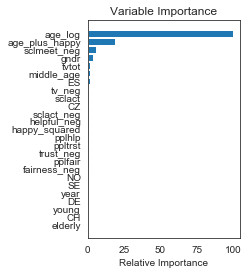

In [315]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [57]:
df.head(3)

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,tv_neg,trust_neg,fairness_neg,helpful_neg,happy_neg,sclmeet_neg,sclact_neg,age_log
0,CH,5.000,6,3.000,3.000,10.000,5.000,8.000,5.000,4.000,2.000,60.000,1.000,4.000,7.000,0.000,5.000,2.000,2.000,1.000,4.094
1,CH,25.000,6,6.000,5.000,7.000,5.000,9.000,3.000,2.000,2.000,59.000,1.000,1.000,5.000,3.000,5.000,1.000,4.000,3.000,4.078
2,CH,26.000,6,1.000,8.000,8.000,8.000,7.000,6.000,3.000,1.000,24.000,2.000,6.000,2.000,2.000,2.000,3.000,1.000,2.000,3.178


Unable to significantly reduce the net error of the model.